In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Libraries

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.preprocessing import OneHotEncoder
#from scipy import sparse
#from scipy.sparse import csr_matrix
#from sklearn.decomposition import IncrementalPCA
import tensorflow as tf
from PIL import Image
import os

# Import Data

In [38]:
articles_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv")
customers_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions_train_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

In [4]:
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [5]:
customers_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [44]:
transactions_train_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


I want to use articles_df to give product recommendation based on similarity between the articles

In [7]:
print(f"Number of rows in articles is {articles_df.shape[0]}")
print(f"Number of columns in articles is {articles_df.shape[1]}")
print("\nInformation of articles:")
articles_df.info()

Number of rows in articles is 105542
Number of columns in articles is 25

Information of articles:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_v

In [8]:
for i in articles_df.columns:
    print(f"{i} has {articles_df[i].nunique()} columns")

article_id has 105542 columns
product_code has 47224 columns
prod_name has 45875 columns
product_type_no has 132 columns
product_type_name has 131 columns
product_group_name has 19 columns
graphical_appearance_no has 30 columns
graphical_appearance_name has 30 columns
colour_group_code has 50 columns
colour_group_name has 50 columns
perceived_colour_value_id has 8 columns
perceived_colour_value_name has 8 columns
perceived_colour_master_id has 20 columns
perceived_colour_master_name has 20 columns
department_no has 299 columns
department_name has 250 columns
index_code has 10 columns
index_name has 10 columns
index_group_no has 5 columns
index_group_name has 5 columns
section_no has 57 columns
section_name has 56 columns
garment_group_no has 21 columns
garment_group_name has 21 columns
detail_desc has 43404 columns


I want to drop columns that represent the same thing. So I will drop
* product_type_no
* graphical_appearance_no
* colour_group_code
* perceived_colour_value_id 
* perceived_colour_master_id
* index_code
* index_group_no
* section_no
* garment_group_no

Among remaining columns I only want to use below columns as my features that has maximum information
Not considering prod_name (It has 45875 columns which is too much of information to handle with our memory)
* product_type_name
* graphical_appearance_name
* colour_group_name
* department_name  

In [26]:
features_columns = ["product_type_name", "graphical_appearance_name", "colour_group_name", "department_name"]

In [27]:
features_df = articles_df[["article_id","product_type_name", "graphical_appearance_name", "colour_group_name", "department_name"]]
features_encoded_df = pd.get_dummies(features_df, columns = features_columns, drop_first = False)


In [42]:
features_encoded_df.shape

(105542, 462)

In [28]:
item_vector = features_encoded_df.set_index("article_id")
item_vector

,product_type_name_Accessories set,product_type_name_Alice band,product_type_name_Baby Bib,product_type_name_Backpack,product_type_name_Bag,product_type_name_Ballerinas,product_type_name_Beanie,product_type_name_Belt,product_type_name_Bikini top,product_type_name_Blanket,...,department_name_Young Girl Jersey Basic,department_name_Young Girl Jersey Fancy,department_name_Young Girl Knitwear,department_name_Young Girl Outdoor,department_name_Young Girl S&T,department_name_Young Girl Shoes,department_name_Young Girl Swimwear,department_name_Young Girl Trouser,department_name_Young Girl UW/NW,department_name_Young boy Swimwear
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
108775044,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
108775051,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
110065001,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
110065002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953450001,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
953763001,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
956217002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [29]:
#we are convertinbg our dataframe to tensor flow tensor to deal with memeory error issue
item_tensor = tf.convert_to_tensor(item_vector, dtype = tf.float32)

In [30]:
normalized_item_tensor = tf.nn.l2_normalize(item_tensor, axis=1)
normalized_item_tensor

<tf.Tensor: shape=(105542, 461), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [31]:
#compute cosine similairty_matrix
cosine_similarity_matrix = tf.matmul(normalized_item_tensor, normalized_item_tensor, transpose_b = True)

In [32]:
cosine_similarity_matrix 

<tf.Tensor: shape=(105542, 105542), dtype=float32, numpy=
array([[0.99999976, 0.7499998 , 0.49999988, ..., 0.49999994, 0.49999994,
        0.24999997],
       [0.7499998 , 0.99999976, 0.49999988, ..., 0.24999997, 0.24999997,
        0.24999997],
       [0.49999988, 0.49999988, 0.99999976, ..., 0.        , 0.        ,
        0.24999997],
       ...,
       [0.49999994, 0.24999997, 0.        , ..., 1.        , 0.5       ,
        0.75      ],
       [0.49999994, 0.24999997, 0.        , ..., 0.5       , 1.        ,
        0.25      ],
       [0.24999997, 0.24999997, 0.24999997, ..., 0.75      , 0.25      ,
        1.        ]], dtype=float32)>

In [33]:
similarity_df = pd.DataFrame(cosine_similarity_matrix, index = item_vector.index, columns = item_vector.index)
similarity_df

article_id,108775015,108775044,108775051,110065001,110065002,110065011,111565001,111565003,111586001,111593001,...,949594001,950449002,952267001,952937003,952938001,953450001,953763001,956217002,957375001,959461001
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,1.00,0.75,0.50,0.50,0.25,0.25,0.50,0.25,0.50,0.50,...,0.25,0.25,0.25,0.00,0.00,0.25,0.75,0.50,0.50,0.25
108775044,0.75,1.00,0.50,0.25,0.50,0.25,0.25,0.25,0.25,0.25,...,0.25,0.25,0.00,0.00,0.00,0.00,0.50,0.25,0.25,0.25
108775051,0.50,0.50,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.25
110065001,0.50,0.25,0.00,1.00,0.75,0.75,0.50,0.25,0.50,0.50,...,0.25,0.25,0.25,0.00,0.00,0.25,0.50,0.50,0.50,0.25
110065002,0.25,0.50,0.00,0.75,1.00,0.75,0.25,0.25,0.25,0.25,...,0.25,0.25,0.00,0.00,0.00,0.00,0.25,0.25,0.25,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953450001,0.25,0.00,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.25,...,0.00,0.00,0.25,0.00,0.00,1.00,0.25,0.25,0.25,0.00
953763001,0.75,0.50,0.25,0.50,0.25,0.25,0.50,0.25,0.50,0.50,...,0.50,0.25,0.25,0.25,0.25,0.25,1.00,0.75,0.50,0.50
956217002,0.50,0.25,0.00,0.50,0.25,0.25,0.50,0.25,0.50,0.50,...,0.50,0.25,0.25,0.50,0.25,0.25,0.75,1.00,0.50,0.75


In [71]:
#Get Top N similar items
article_id = 952938001
top_n = 12

similar_articles = similarity_df[article_id].nlargest(top_n + 1).iloc[1:]
print(similar_articles)

article_id
664074010    1.00
664074057    1.00
710060001    1.00
715779003    1.00
763451003    1.00
770916002    1.00
849584007    1.00
269342027    0.75
361401005    0.75
361467024    0.75
361467038    0.75
506166050    0.75
Name: 952938001, dtype: float32


In [77]:
# Function to display main article image and similar articles images
def display_similar_articles(article_id, similar_articles, img_dir, target_size=(224, 224)):
    total_articles = len(similar_articles) + 1  # Count main article + similar articles
    plt.figure(figsize=(10, total_articles * 5))  # Adjust figure height based on number of articles

    # Path for the main article image
    main_subfolder = '0' + str(article_id)[:2]
    main_img_path = os.path.join(img_dir, main_subfolder, f'0{article_id}.jpg')

    # Display the main article image
    print(f"We are looking for recommendations (similarity) of the'0{article_id}:")
    plt.subplot(total_articles, 1, 1)  # Main article in the first row
    if os.path.exists(main_img_path):
        img = Image.open(main_img_path).resize(target_size)  # Resize image
        plt.imshow(img)
        plt.title(f'Article ID: {article_id}')
    else:
        print(f"Image for Article ID {article_id} not found.")
        plt.imshow(np.ones((target_size[0], target_size[1], 3)))  # Placeholder if not found
        plt.title(f'Article ID: {article_id} (Not Found)')
    plt.axis('off')

    # Display images for similar articles
    print("Here are the articles similar to the given article:")
    for idx, similar_id in enumerate(similar_articles.index):  # Enumerate through similar articles
        similar_subfolder = '0' + str(similar_id)[:2]  # Get subfolder for each similar article
        similar_img_path = os.path.join(img_dir, similar_subfolder, f'0{similar_id}.jpg')

        plt.subplot(total_articles, 1, idx + 2)  # Set each similar article in a new row
        if os.path.exists(similar_img_path):
            img = Image.open(similar_img_path).resize(target_size)  # Resize image
            plt.imshow(img)
            plt.title(f'Similar ID: {similar_id}')
        else:
            print(f"Image for Similar Article ID {similar_id} not found.")
            plt.imshow(np.ones((target_size[0], target_size[1], 3)))  # Placeholder if not found
            plt.title(f'Similar ID: {similar_id} (Not Found)')
        plt.axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

We are looking for recommendations (similarity) of the'0952938001:
Here are the articles similar to the given article:


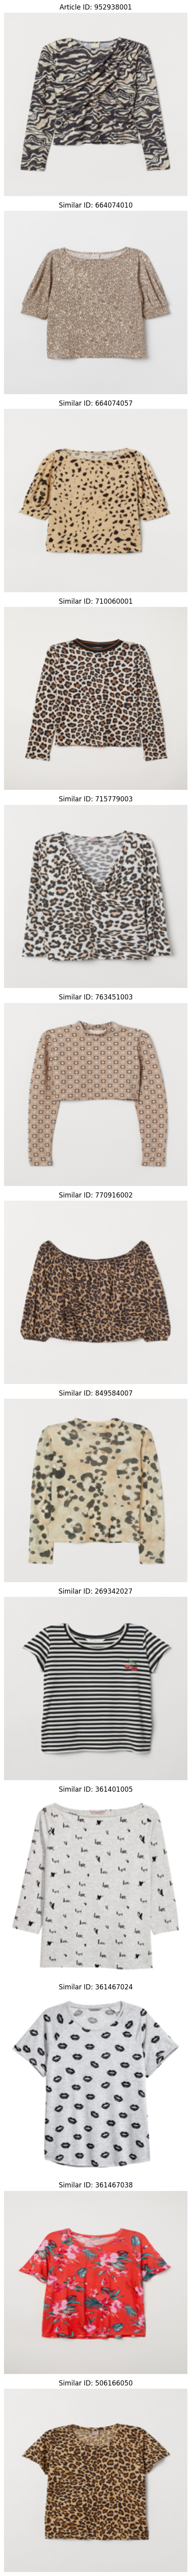

In [78]:
img_dir = '/kaggle/input/h-and-m-personalized-fashion-recommendations/images'

display_similar_articles(article_id, similar_articles, img_dir)